## Helper functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

In [2]:
# Removes from X the specified features
def rm_feature(X, omitted_features):
    X = X.drop(columns=omitted_features)
    return X

In [3]:
def get_categorical_features(X):
    column_types = X.dtypes
    categorical_features = column_types[column_types == 'object'].index.tolist()
    return categorical_features


In [4]:
def one_hot_encoding(X, categorical_features):
    X_one_hot = pd.get_dummies(X, columns=categorical_features,dtype=int)
    return X_one_hot


In [5]:
class FeatureSelector():
    def __init__(self, cv_size = 10, take_logs = True):
        self.k_fold_splitter = KFold(n_splits=cv_size, random_state=1,
                                     shuffle=True)

        self.take_logs = take_logs


    def rmsle(self, y, y_pred, **kwargs):
        y_true = y
        if self.take_logs:
            y_true = np.exp(y) - 1
            y_pred = np.exp(y_pred) - 1
        y_pred = np.maximum(0, y_pred)
        return np.sqrt(np.mean((np.log(1 + y_true) - np.log(1 + y_pred))**2))

    def stepwise_feature_selection(self, X, y, estimator, forward,
                                   n_features_to_select = 10,
                                   score_function = 'auto'):

        if score_function == 'auto':
            score_func = make_scorer(self.rmsle, greater_is_better=False)
        else:
            score_func = score_function

        sfs = SFS(
            estimator,
            k_features = n_features_to_select,
            forward=forward,
            floating=False,
            scoring = score_func,
            cv=self.k_fold_splitter,
            n_jobs=-1
        )
        print(type(X))
        y_to_fit = np.log(y+1) if self.take_logs else y
        sfs.fit(X, y_to_fit)
        return sfs

    def k_fold_cv(self, model, X, y):
        score_function = make_scorer(self.rmsle)
        y_to_fit = np.log(y+1) if self.take_logs else y
        scores = cross_val_score(model,
            X,
            y_to_fit,
            scoring = score_function,
            cv = self.k_fold_splitter,
            n_jobs = -1)
        return np.mean(scores)


    def select_best_subset(self, X, y, estimator, forward,
                           n_features_to_select = 10,
                           score_function = 'auto'):
        sfs = self.stepwise_feature_selection(X, y,
                                              estimator,
                                              forward,
                                              n_features_to_select,
                                              score_function)
        subsets = sfs.subsets_
        best_subset = max(subsets.values(), key = lambda x: x['avg_score'])
        return list(best_subset['feature_idx'])



## Test

In [6]:
train = pd.read_csv("phone_train.csv")
test = pd.read_csv("phone_validation.csv")

# Encode train and test sets
X_train = rm_feature(train, ['y'])
y_train = train['y']
X_test = test

In [174]:
print(train.head(10))
print(test.head(10))

   tariff.plan           payment.method sex    age  activation.zone  \
0            6         Carta di Credito   M  34.29                3   
1            8         Carta di Credito   M  22.78                2   
2            7         Carta di Credito   B  26.95                3   
3            6  Domiciliazione Bancaria   B  46.09                2   
4            8       Bollettino Postale   M  23.77                2   
5            7         Carta di Credito   B  22.03                2   
6            8         Carta di Credito   M  34.22                1   
7            8         Carta di Credito   F  24.75                1   
8            8         Carta di Credito   F  32.88                1   
9            3         Carta di Credito   B  51.93                1   

   activation.channel vas1 vas2  q01.out.ch.peak  q01.out.dur.peak  ...  \
0                   5    N    N               82              6390  ...   
1                   9    N    N                0                 0  

In [7]:
cat_features = get_categorical_features(X_train)
cat_features = cat_features + ['activation.zone', 'activation.channel',
                               'tariff.plan']
cat_features

['payment.method',
 'sex',
 'vas1',
 'vas2',
 'activation.zone',
 'activation.channel',
 'tariff.plan']

In [8]:
X_train['label'] = 'train'
X_test['label'] = 'test'



concat_X = pd.concat([X_train, X_test])
concat_X = one_hot_encoding(concat_X, cat_features + ['label'])

X_train = concat_X[concat_X['label_train']==1]
X_test = concat_X[concat_X['label_test']==1]

X_train = X_train.drop(['label_train','label_test'], axis=1)
X_test = X_test.drop(['label_train','label_test'], axis=1)


In [111]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Columns: 119 entries, age to tariff.plan_8
dtypes: float64(19), int32(28), int64(72)
memory usage: 8.1 MB


### Forward stepwise selection

In [112]:
model = LinearRegression()
feature_selector = FeatureSelector()
sfs = feature_selector.stepwise_feature_selection(X_train, y_train, model, True,
                                 n_features_to_select="best")
X_train_sfs = sfs.transform(X_train)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:
X_train[list(sfs.k_feature_names_)]

,age,q01.out.ch.peak,q01.out.ch.offpeak,q01.out.val.offpeak,q01.in.dur.tot,q01.ch.sms,q02.out.ch.peak,q02.ch.sms,q03.out.dur.offpeak,q03.in.ch.tot,...,vas1_Y,vas2_N,vas2_Y,activation.zone_0,activation.zone_2,activation.channel_8,activation.channel_9,tariff.plan_3,tariff.plan_4,tariff.plan_8
0,34.29,82,0,0.0000,4154,6,70,0,0,78,...,0,1,0,0,0,0,0,0,0,0
1,22.78,0,0,0.0000,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
2,26.95,244,0,0.0000,16351,0,392,2,0,263,...,1,1,0,0,0,0,0,0,0,0
3,46.09,331,0,0.0000,41517,0,303,0,0,499,...,1,1,0,0,1,0,0,0,0,0
4,23.77,0,0,0.0000,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23.01,0,0,0.0000,0,0,0,0,0,13,...,0,1,0,0,1,0,0,0,0,1
9996,44.72,24,6,2.3788,1113,0,13,0,153,17,...,0,1,0,0,1,0,0,0,0,0
9997,17.47,0,0,0.0000,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
9998,21.67,0,0,0.0000,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1


In [ ]:
# Test model with subset features
feature_selector.k_fold_cv(LinearRegression(), X_train_sfs, y_train)

2.432767864867283

In [ ]:
# Test model with all features
feature_selector.k_fold_cv(LinearRegression(), X_train, y_train)

2.463238898092651

### Prediction on X_test

In [113]:
X_test_sfs = sfs.transform(X_test)

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:
model = LinearRegression()
model.fit(X_train_sfs, np.log(y_train + 1))
y_pred = np.exp(model.predict(X_test_sfs)) - 1
y_pred = np.maximum(0, y_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('mySubmission.txt', index=False, header=False, sep='\t')

## KNN regression

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor as KNN

In [115]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNN(n_neighbors = 10))])

feature_selector = FeatureSelector()

sfs_knn = feature_selector.stepwise_feature_selection(X_train, y_train,
                                                      pipe, True,
                                                      n_features_to_select=10)

In [116]:
X_train[list(sfs_knn.k_feature_names_)]

,q08.out.ch.peak,q09.out.ch.peak,q09.out.dur.peak,q09.out.ch.offpeak,q09.ch.sms,activation.zone_0,activation.zone_4,tariff.plan_3,tariff.plan_4,tariff.plan_6
0,70,77,6786,0,0,0,0,0,0,1
1,23,16,841,0,1,0,0,0,0,0
2,131,343,72632,0,0,0,0,0,0,0
3,167,261,26602,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,16,5,196,0,4,0,0,0,0,0
9996,21,83,6962,0,0,0,0,0,0,0
9997,0,9,758,0,0,0,0,0,0,0
9998,24,32,3841,0,38,0,0,0,0,0


In [117]:
X_train_sfs_knn = sfs_knn.transform(X_train)
feature_selector.k_fold_cv(pipe, X_train_sfs_knn, y_train)

2.0779821680262787

In [118]:
X_test_sfs_knn = sfs_knn.transform(X_test)

In [119]:
pipe.fit(X_train_sfs_knn, np.log(y_train + 1))
y_pred = np.exp(pipe.predict(X_test_sfs_knn)) - 1
y_pred = np.maximum(0, y_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('mySubmission_knn.txt', index=False, header=False, sep='\t')

## Principal Component Regression (PCR)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pcr = LinearRegression()
pca = PCA()
feature_selector = FeatureSelector()
X_train_pca = pca.fit_transform(X_train)

sfs_pcr = feature_selector.stepwise_feature_selection(X_train_pca, y_train,
                                                      pcr, True,
                                                      n_features_to_select=20)

In [ ]:
X_train_sfs_pcr = sfs_pcr.transform(X_train_pca)

In [ ]:
feature_selector.k_fold_cv(pcr, X_train_sfs_pcr, y_train)

2.529566742804975

## KNN best subsets

In [104]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNN(n_neighbors = 10))])

feature_selector = FeatureSelector()

best_features = feature_selector.select_best_subset(X_train, y_train,
                                                      pipe, True,
                                                      n_features_to_select=15)


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 876, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 912, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'train'


In [ ]:
X_train_best_knn = X_train[X_train.columns[best_features]]
X_train_best_knn

,q08.out.ch.peak,q09.out.ch.peak,q09.out.ch.offpeak,q09.out.val.offpeak,q09.ch.sms,vas2_N,activation.zone_0,tariff.plan_3
0,70,77,0,0.0,0,1,0,0
1,23,16,0,0.0,1,1,0,0
2,131,343,0,0.0,0,1,0,0
3,167,261,0,0.0,0,1,0,0
4,0,0,0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...
9995,16,5,0,0.0,4,1,0,0
9996,21,83,0,0.0,0,1,0,0
9997,0,9,0,0.0,0,0,0,0
9998,24,32,0,0.0,38,1,0,0


In [ ]:
feature_selector.k_fold_cv(pipe, X_train_best_knn, y_train)

2.0828821366942827

In [ ]:
X_test_best_knn = X_test[X_test.columns[best_features]]

In [ ]:
pipe.fit(X_train_best_knn, np.log(y_train + 1))
y_pred = np.exp(pipe.predict(X_test_best_knn)) - 1
y_pred = np.maximum(0, y_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('mySubmission_knn_best_subset.txt', index=False, header=False, sep='\t')

## Gradient boosting regresion 



In [141]:
pipe = Pipeline([
                 ('model', GradientBoostingRegressor(n_estimators=100))])

X_train_sfs_knn = sfs_knn.transform(X_train)
result = feature_selector.k_fold_cv(pipe, X_train_sfs_knn, y_train)
print(result)


2.0032679061166485


## TODO:
- Refactor code
- Try different values of K (of KNN) (cross validation? maybe too long to computr)
- Try to perform PCR
- Try Stepwise selection with different regressors
- Analyse residuals

## Analyze data acording to months

The goal is to predict total monthly duration (in seconds) of outgoing calls in the tenth month. The fact that it is in the 10 th month rises question if we can use data only from the 10 th month or few moths before. 
Let's explore it here 

In [143]:
names_month_variables = [  
  '.out.ch.peak',                    #total monthly number of outgoing calls at times when the tariff is highest
  '.out.dur.peak',                    #total monthly duration of outgoing calls at times when the tariff is highest
  '.out.val.peak',                    #total monthly value of outgoing calls at times when the tariff is highest
  '.out.ch.offpeak',                 #total monthly number of outgoing calls during offpeak hours
  '.out.dur.offpeak',                #total monthly duration of outgoing calls during off-peak hours
  '.out.val.offpeak',                #total monthly value of outgoing calls during off-peak hours
  '.in.ch.tot',                      #     monthly number of incoming calls
  '.in.dur.tot',                     #     monthly duration of incoming calls
  '.ch.sms',                         #     monthly number of SMS sent
  '.ch.cc',                          #     monthly number of calls to the Customer Service Centre
]
months = ['q01','q02','q03','q04','q05','q06','q07','q08','q09']
# does mean value of predictors differ in each month?
def month_means(features, months: list[str]):
    description = train.describe()
    means = description.loc['mean']
  
    fig, axs = plt.subplots(len(features))
    fig.suptitle('means of features')
    fig.set_figheight(10)
    for i,feature in enumerate(features):
        feature_means = [means[m + feature] for m in months]
        axs[i].bar(months, feature_means)
        axs[i].title.set_text( feature)
    plt.show()


display(train.describe())
#month_means(names_month_variables[0:3], months=months)
#month_means(names_month_variables[3:6], months=months)
#month_means(names_month_variables[6:9], months=months)



,tariff.plan,age,activation.zone,activation.channel,q01.out.ch.peak,q01.out.dur.peak,q01.out.val.peak,q01.out.ch.offpeak,q01.out.dur.offpeak,q01.out.val.offpeak,...,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.063500,29.931764,2.071600,5.601000,50.966400,5585.040000,28.887726,7.417000,866.482100,3.209234,...,12840.253900,58.581401,2.455700,309.700100,1.003160,85.79290,8967.418000,4.484200,0.517500,1595.301300
std,1.368304,9.877363,0.980495,1.585576,111.950881,14167.020367,72.202958,25.508159,3467.459456,16.076691,...,20882.049468,86.938909,13.521987,2080.944474,6.114525,111.70579,13139.898911,27.410335,2.030494,6076.415038
min,3.000000,14.810000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,21.340000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,875.000000,5.609075,0.000000,0.000000,0.000000,9.00000,442.000000,0.000000,0.000000,0.000000
50%,7.000000,28.450000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4909.000000,27.239000,0.000000,0.000000,0.000000,47.00000,3938.500000,0.000000,0.000000,165.000000
75%,8.000000,37.470000,3.000000,5.000000,55.000000,4592.500000,28.338400,1.000000,51.000000,0.313625,...,15519.500000,75.294375,0.000000,0.000000,0.000000,121.00000,12056.000000,0.000000,0.000000,956.250000
max,8.000000,52.650000,4.000000,9.000000,1962.000000,273727.000000,2858.310000,952.000000,84071.000000,1041.436900,...,358501.000000,1331.092300,293.000000,87497.000000,173.571400,1494.00000,217274.000000,845.000000,59.000000,146293.000000


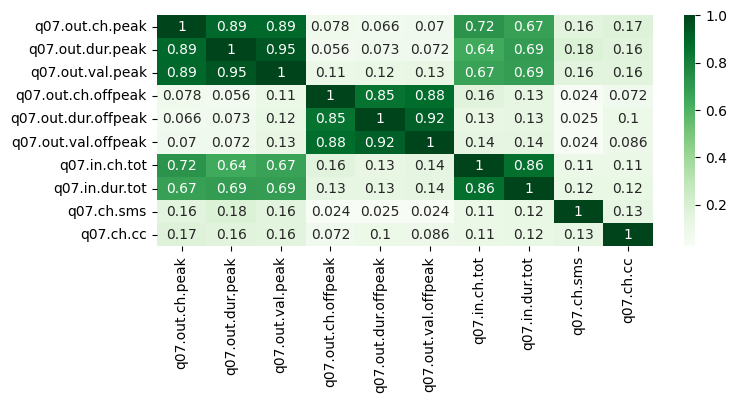

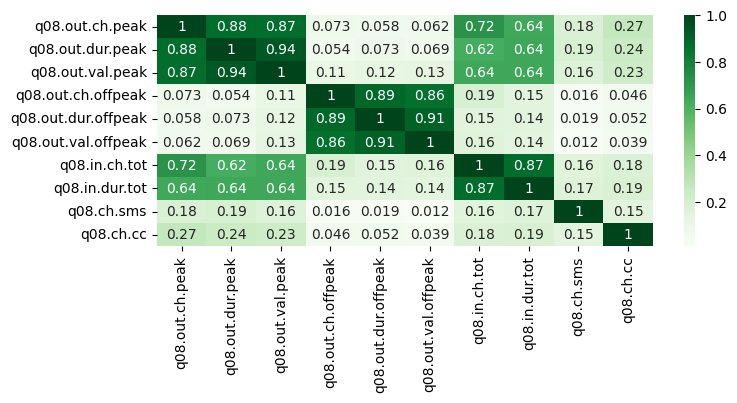

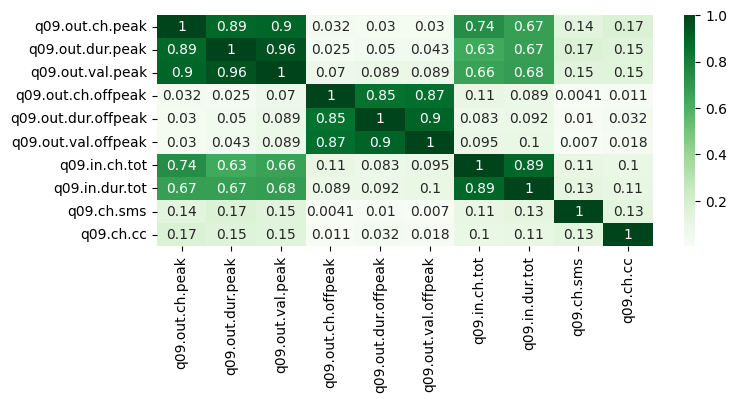

In [162]:
def corr_matrix(number):
   month = train.loc[:, [number + name for name in names_month_variables]] 
   
   corr = month.corr()
   corr.style.background_gradient(cmap='coolwarm')
   corr.style.background_gradient(cmap='coolwarm').format(precision=2)
   plt.figure(figsize=(8,3))
   sns.heatmap(corr, cmap="Greens",annot=True)
   plt.show()

for month in months[6:9]:
   corr_matrix(month)

In [145]:
# highly correlated features 
# ['.out.ch.peak','.out.dur.peak', '.out.val.peak']
# ['.out.ch.offpeak', '.out.dur.offpeak', '.out.val.offpeak']
# ['.in.ch.tot', '.in.dur.tot']

# non categorical features ['']
raw_concat = pd.concat((train, test))
unique_values = {}
for feature in cat_features:
    unique_values[feature] = raw_concat[feature].unique()
print(unique_values)
print(cat_features)

non_cat_features = ['age']
month_features1 = ['.out.dur.peak','.out.dur.offpeak','.in.dur.tot', '.ch.sms', '.ch.cc']
# categorical features: ['payment.method', 'sex', 'vas1', 'vas2', 'activation.zone', 'activation.channel', 'tariff.plan']

unique_values['activation.zone'] = unique_values['activation.zone'].sort()
unique_values['activation.channel'] = unique_values['activation.channel'].sort()
unique_values['tariff.plan'] = unique_values['tariff.plan'].sort()


{'payment.method': array(['Carta di Credito', 'Domiciliazione Bancaria',
       'Bollettino Postale'], dtype=object), 'sex': array(['M', 'B', 'F'], dtype=object), 'vas1': array(['N', 'Y'], dtype=object), 'vas2': array(['N', 'Y'], dtype=object), 'activation.zone': array([3, 2, 1, 4, 0], dtype=int64), 'activation.channel': array([5, 9, 7, 3, 8, 2, 4, 6], dtype=int64), 'tariff.plan': array([6, 8, 7, 3, 4], dtype=int64)}
['payment.method', 'sex', 'vas1', 'vas2', 'activation.zone', 'activation.channel', 'tariff.plan']


In [177]:
def add_month(month, names):
    return [month + name for name in names]


['payment.method', 'sex', 'vas1', 'vas2', 'activation.zone', 'activation.channel', 'tariff.plan']


In [186]:



class is_categorical:
    def __call__(self, x):
       
        return True #x in ['payment.method', 'sex', 'vas1', 'vas2', 'activation.zone', 'activation.channel', 'tariff.plan']

def test_one_month(months, month_features):
    features_names= []
    for m in months:
        features_names = features_names + add_month(m, month_features)
    features_names =  features_names + non_cat_features + cat_features 
    one_hot = OneHotEncoder()
    pattern = cat_features[0]
    for f in cat_features[1:]: pattern += '|'+ f
     
    transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                     remainder= 'passthrough')
    pipe = Pipeline([
                     ('preprocessing', transformer),
                     ('model', GradientBoostingRegressor(n_estimators=150))])
    X_train_gb = train.loc[:,features_names]
    result = feature_selector.k_fold_cv(pipe, X_train_gb, y_train)
    print(months,' ',result)

for m in months:
   test_one_month([m],month_features1)


test_one_month(['q09','q08', 'q07','q06','q05'], month_features1)

test_one_month(['q09','q08', 'q07','q06','q05'], ['.out.dur.peak','.out.dur.offpeak','.in.dur.tot', '.ch.sms'])
test_one_month(['q09','q08', 'q07','q06','q05'], ['.out.dur.peak','.out.dur.offpeak','.in.dur.tot', '.ch.cc'])
test_one_month(['q09','q08', 'q07','q06','q05'], ['.out.dur.peak','.out.dur.offpeak', '.ch.sms', '.ch.cc'])
test_one_month(['q09','q08', 'q07','q06','q05'], ['.out.dur.peak','.in.dur.tot', '.ch.sms', '.ch.cc'])
test_one_month(['q09','q08', 'q07','q06','q05'], ['.out.dur.offpeak','.in.dur.tot', '.ch.sms', '.ch.cc'])
print(['.out.dur.peak','.out.dur.offpeak','.in.dur.tot', '.ch.sms','.out.ch.peak','.out.ch.offpeak','.in.ch.tot'])
test_one_month(['q09','q08', 'q07','q06','q05'], ['.out.dur.peak','.out.dur.offpeak','.in.dur.tot', '.ch.sms','.out.ch.peak','.out.ch.offpeak','.in.ch.tot'])
print(['.out.dur.peak','.out.dur.offpeak','.in.dur.tot', '.ch.sms','.out.ch.peak','.out.ch.offpeak','.in.ch.tot','.out.val.peak','.out.val.offpeak'])
test_one_month(['q09','q08', 'q07','q06','q05'], ['.out.dur.peak','.out.dur.offpeak','.in.dur.tot', '.ch.sms','.out.ch.peak','.out.ch.offpeak','.in.ch.tot','.out.val.peak','.out.val.offpeak'])



['q01']   2.6540657942053842
['q02']   2.6378063802377025
['q03']   2.6114976428360115
['q04']   2.5814197736674576
['q05']   2.544707717294497
['q06']   2.5067880359531935
['q07']   2.421896645171622
['q08']   2.374104282049693
['q09']   2.019354791012415
['q09', 'q08', 'q07', 'q06', 'q05']   2.008707910332914
['q09', 'q08', 'q07', 'q06', 'q05']   2.008224256625948
['q09', 'q08', 'q07', 'q06', 'q05']   2.0112625771284653
['q09', 'q08', 'q07', 'q06', 'q05']   2.020398563329849
['q09', 'q08', 'q07', 'q06', 'q05']   2.095024997232577
['q09', 'q08', 'q07', 'q06', 'q05']   2.2136753113744367
['.out.dur.peak', '.out.dur.offpeak', '.in.dur.tot', '.ch.sms', '.out.ch.peak', '.out.ch.offpeak', '.in.ch.tot']
['q09', 'q08', 'q07', 'q06', 'q05']   1.9870143868243688
['.out.dur.peak', '.out.dur.offpeak', '.in.dur.tot', '.ch.sms', '.out.ch.peak', '.out.ch.offpeak', '.in.ch.tot', '.out.val.peak', '.out.val.offpeak']
['q09', 'q08', 'q07', 'q06', 'q05']   1.9870739951374108


In [187]:

test_one_month(['q09','q08', 'q07','q06','q05'], month_features1)

c:\Users\proko\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['q09', 'q08', 'q07', 'q06', 'q05']   2.0088458693338276


## Choosing features by their name 

In [242]:
import time

class FeaturesSubset:
    def __init__(self, cat_features, non_cat_features, months, month_features_names) -> None:
        self.cat_features = cat_features
        self.non_cat_features = non_cat_features
        self.months = months
        self.month_features_names = month_features_names

class My_Forward_selector:
 
    def evaluate_model(X : pd.DataFrame,y,estimator, features):
        feature_selector = FeatureSelector()
        X_train = X.loc[:,features]
        result = feature_selector.k_fold_cv(estimator, X_train, y)
        return result

    def forward_selection(X : pd.DataFrame,y,estimator, max, features):
        features_left = features
        best_features = []
        best_score = []
        actual_features = []
        for i in range(max):
            print(f"using {i+1} features")
            start = time.time()
            used_features = []
            score = []
            if features_left == []: break
                
            for f in features_left:

                result = My_Forward_selector.evaluate_model(X, y, estimator, actual_features + [f])
                score.append(result)
                used_features.append(actual_features + [f])
            
            print(f"beast score for { i + 1} features: {min(score)}")
            
            best_features.append(used_features[score.index(min(score))])
            best_score.append(min(score))
            actual_features = best_features[-1]
            print(f"new feature: { actual_features[-1]}")
            
            features_left.remove(actual_features[-1])
            end = time.time()
            print(f"time {end - start}")
            print('='*20)
        return (best_score,best_features)

def features_subset(data : pd.DataFrame, fs : FeaturesSubset) -> pd.DataFrame:
    month_features = []
    for m in fs.months:
        for mfname in fs.month_features_names:
            month_features.append(m + mfname)

    features = fs.non_cat_features + fs.cat_features + month_features
    return data.loc[:, features], features

def best_subset(pipe, fs : FeaturesSubset, output_features):
    one_hot = OneHotEncoder()
    pattern = cat_features[0]
    for f in cat_features[1:]: pattern += '|'+ f
     
    transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                     remainder= 'passthrough')
    pipe_w_preprocessing = Pipeline([('preprocessing', transformer)] + pipe)
    train_x, features = features_subset(train, fs)
    print(f"choosing from {features}")
    start = time.time()
    best_scores ,best_features = My_Forward_selector.forward_selection(train_x, y_train, pipe_w_preprocessing, output_features, features)
    end = time.time()
    print(f"feature selection took: {end - start}s")
    best_s = min(best_scores)
    best_f = best_features[best_scores.index(best_s)]

    plt.plot(best_scores)
    plt.title('feature selection, 5-fold cross-validation')
    plt.show()
    print(f"best score: {best_s}")
    print(f"features: {best_f}")

    print("all bests cores:")
    print('  ', best_scores)
    print("all bests features:")
    print('  ', best_features)
    
    print('-'*20)
    return best_f
    


choosing from ['age', 'payment.method', 'sex', 'vas1', 'vas2', 'activation.zone', 'activation.channel', 'tariff.plan', 'q04.out.dur.peak', 'q04.out.dur.offpeak', 'q04.in.dur.tot', 'q04.ch.sms', 'q04.out.ch.peak', 'q04.out.ch.offpeak', 'q04.in.ch.tot', 'q05.out.dur.peak', 'q05.out.dur.offpeak', 'q05.in.dur.tot', 'q05.ch.sms', 'q05.out.ch.peak', 'q05.out.ch.offpeak', 'q05.in.ch.tot', 'q06.out.dur.peak', 'q06.out.dur.offpeak', 'q06.in.dur.tot', 'q06.ch.sms', 'q06.out.ch.peak', 'q06.out.ch.offpeak', 'q06.in.ch.tot', 'q07.out.dur.peak', 'q07.out.dur.offpeak', 'q07.in.dur.tot', 'q07.ch.sms', 'q07.out.ch.peak', 'q07.out.ch.offpeak', 'q07.in.ch.tot', 'q08.out.dur.peak', 'q08.out.dur.offpeak', 'q08.in.dur.tot', 'q08.ch.sms', 'q08.out.ch.peak', 'q08.out.ch.offpeak', 'q08.in.ch.tot', 'q09.out.dur.peak', 'q09.out.dur.offpeak', 'q09.in.dur.tot', 'q09.ch.sms', 'q09.out.ch.peak', 'q09.out.ch.offpeak', 'q09.in.ch.tot']
using 1 features
beast score for 1 features: 2.4129802613799365
new feature: q09.ou

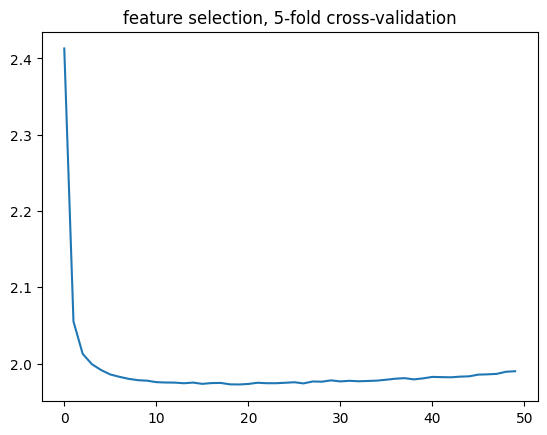

best score: 1.9727187079979533
features: ['q09.out.ch.peak', 'q09.out.ch.offpeak', 'tariff.plan', 'age', 'q09.out.dur.peak', 'q05.in.ch.tot', 'q08.out.ch.peak', 'q06.out.dur.peak', 'q07.out.ch.peak', 'vas1', 'vas2', 'q09.in.ch.tot', 'activation.zone', 'q08.out.dur.offpeak', 'q08.ch.sms', 'activation.channel', 'q08.out.ch.offpeak', 'q05.ch.sms', 'q04.in.ch.tot', 'payment.method']
all bests cores:
   [2.4129802613799365, 2.055298898303044, 2.012903954369683, 1.9993131326594196, 1.9916511230494691, 1.985841405299221, 1.9827441794347116, 1.980100444019456, 1.978346947483691, 1.9777212793472025, 1.9757706451928052, 1.9753056298643805, 1.9751718397358489, 1.974319191699395, 1.9752044899677021, 1.973526815039247, 1.9745746464254843, 1.9747357764762008, 1.972908380484918, 1.9727187079979533, 1.973407085007168, 1.9749711055755281, 1.974369663975573, 1.9743657974763376, 1.9749532989977379, 1.9756470391072312, 1.974136926593965, 1.9766571407182496, 1.9763862796258558, 1.9781003784766291, 1.976734

In [243]:

selector = FeaturesSubset(
    cat_features = cat_features,
    non_cat_features = non_cat_features,
    months = ['q04','q05','q06','q07','q08','q09'],
    month_features_names = ['.out.dur.peak', '.out.dur.offpeak', '.in.dur.tot', '.ch.sms', '.out.ch.peak', '.out.ch.offpeak', '.in.ch.tot']
)

pipe = [('gb',GradientBoostingRegressor(n_estimators=150))]

best_features_gb = best_subset(pipe, selector, 50)

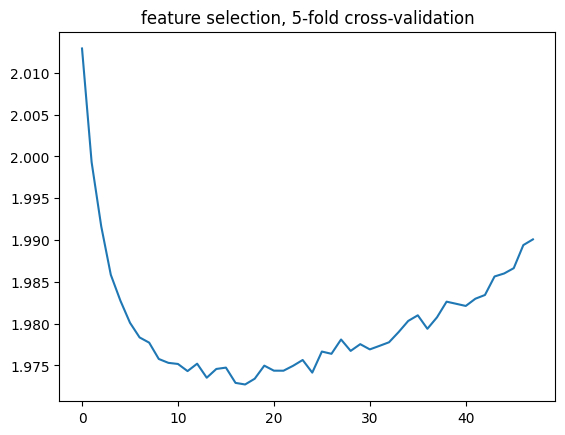

In [250]:
best_gb_fs = [2.4129802613799365, 2.055298898303044, 2.012903954369683, 1.9993131326594196, 1.9916511230494691, 1.985841405299221, 1.9827441794347116, 1.980100444019456, 1.978346947483691, 1.9777212793472025, 1.9757706451928052, 1.9753056298643805, 1.9751718397358489, 1.974319191699395, 1.9752044899677021, 1.973526815039247, 1.9745746464254843, 1.9747357764762008, 1.972908380484918, 1.9727187079979533, 1.973407085007168, 1.9749711055755281, 1.974369663975573, 1.9743657974763376, 1.9749532989977379, 1.9756470391072312, 1.974136926593965, 1.9766571407182496, 1.9763862796258558, 1.9781003784766291, 1.9767346204562883, 1.9775404800504657, 1.9769151672677652, 1.9773342968713237, 1.977766382511924, 1.9789849102636778, 1.9803168298629248, 1.9809922591442883, 1.9793791807131704, 1.9807488750682487, 1.9826223814588957, 1.982368471063301, 1.9821107012610377, 1.9829745348005947, 1.9834207742858265, 1.9856355214298287, 1.9859951949667807, 1.9866292122547577, 1.98939036528157, 1.9900727104904448]

plt.plot(best_gb_fs[2:])
plt.title('feature selection, 5-fold cross-validation')
plt.show()

In [23]:
#['q09.out.ch.peak', 'q09.out.ch.offpeak', 'tariff.plan', 'age', 'q09.out.dur.peak', 'q05.in.ch.tot', 'q08.out.ch.peak', 'q06.out.dur.peak', 'q07.out.ch.peak', 'vas1', 'vas2', 'q09.in.ch.tot', 'activation.zone', 'q08.out.dur.offpeak', 'q08.ch.sms', 'activation.channel', 'q08.out.ch.offpeak', 'q05.ch.sms', 'q04.in.ch.tot', 'payment.method']
best_features_fs = ['tariff.plan',
                  'age',
                  'vas1', 
                  'vas2',
                  'payment.method',
                  'activation.zone',
                  'activation.channel',
                  'q09.out.ch.peak', 'q09.out.dur.peak',    'q09.out.ch.offpeak', 'q09.in.ch.tot',
                  'q08.out.ch.peak', 'q08.out.dur.offpeak', 'q08.out.ch.offpeak', 'q08.ch.sms',
                  'q07.out.ch.peak', 
                  'q06.out.dur.peak', 
                  'q05.in.ch.tot', 'q05.ch.sms',           
                  'q04.in.ch.tot']

choosen_features = ['tariff.plan',
                    'age',
                    'vas1', 
                    'vas2',
                    'payment.method',
                    'activation.zone',
                    'activation.channel',
                    'q09.out.ch.peak', 'q09.out.dur.peak','q09.out.dur.offpeak', 'q09.out.ch.offpeak', 'q09.in.ch.tot',
                    'q08.out.ch.peak', 'q08.out.dur.peak','q08.out.dur.offpeak', 'q08.out.ch.offpeak', 'q08.in.ch.tot', 'q08.ch.sms',
                    'q07.out.ch.peak', 'q07.out.dur.peak', 'q07.in.ch.tot',
                    'q06.out.ch.peak', 'q06.out.dur.peak', 'q06.in.ch.tot',
                    'q05.in.ch.tot', 'q05.ch.sms',           
                    'q04.in.ch.tot']

def test_features(features, pipe):

    one_hot = OneHotEncoder()
    pattern = cat_features[0]
    for f in cat_features[1:]: pattern += '|'+ f
     
    transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                     remainder= 'passthrough')
    pipe = Pipeline([('preprocessing', transformer)] + pipe)
    X_train_gb = train.loc[:,features]
    feature_selector = FeatureSelector()
    result = feature_selector.k_fold_cv(pipe, X_train_gb, y_train)
    print(f"result: {result}")

#best score: 1.9727187079979533

In [43]:
test_features(best_features_fs,[('gb',GradientBoostingRegressor())])
grid = {'gb__n_estimators': [100, 120, 150,],
        'gb__max_depth':[2,3,4],
        'gb__learning_rate' :[0.1,0.05]
        }
score_function = make_scorer(FeatureSelector().rmsle,greater_is_better=False)
one_hot = OneHotEncoder()
pattern = cat_features[0]
for f in cat_features[1:]: pattern += '|'+ f
 
transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                 remainder= 'passthrough')
pipe = Pipeline([('preprocessing', transformer),('gb',GradientBoostingRegressor(n_estimators=150))] )
X_train_gb = train.loc[:, best_features_fs]
y_to_fit = np.log(y_train+1) 
grid_search = GridSearchCV(pipe,grid,verbose=4,scoring =score_function)
grid = grid_search.fit(X_train_gb,y_to_fit )
results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
results.to_csv('results-gridSearch-gb-fs.csv')
display(results)


result: 1.9785259461302247
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-1.963 total time=   1.1s
[CV 2/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-2.031 total time=   1.1s
[CV 3/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-1.982 total time=   1.1s
[CV 4/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-2.014 total time=   1.1s
[CV 5/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-2.008 total time=   1.1s
[CV 1/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=120;, score=-1.959 total time=   1.3s
[CV 2/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=120;, score=-2.029 total time=   1.3s
[CV 3/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=120;, score=-1.979 total time=   1.3s
[CV 4/5] END gb__learning_rate=0.1, gb__max_dept

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gb__learning_rate,param_gb__max_depth,param_gb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,3.344284,0.032064,0.008632,0.000867,0.05,4,150,"{'gb__learning_rate': 0.05, 'gb__max_depth': 4...",-1.929706,-2.015230,-1.963712,-1.990669,-1.990019,-1.977867,0.029077,1
6,2.213275,0.011927,0.006891,0.000199,0.1,4,100,"{'gb__learning_rate': 0.1, 'gb__max_depth': 4,...",-1.926022,-2.015097,-1.960035,-1.995404,-1.993248,-1.977961,0.031420,2
7,2.708651,0.086325,0.007398,0.000370,0.1,4,120,"{'gb__learning_rate': 0.1, 'gb__max_depth': 4,...",-1.925049,-2.016677,-1.961903,-1.993682,-1.993496,-1.978161,0.031764,3
16,2.755116,0.082772,0.008236,0.000187,0.05,4,120,"{'gb__learning_rate': 0.05, 'gb__max_depth': 4...",-1.937796,-2.015926,-1.968577,-1.992827,-1.995176,-1.982060,0.026743,4
8,3.406788,0.051957,0.008747,0.000621,0.1,4,150,"{'gb__learning_rate': 0.1, 'gb__max_depth': 4,...",-1.925551,-2.018435,-1.968336,-1.996456,-2.004775,-1.982711,0.032942,5
4,2.068391,0.032824,0.006833,0.000408,0.1,3,120,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3,...",-1.945510,-2.016012,-1.965030,-2.001652,-1.991849,-1.984011,0.025453,6
5,2.532003,0.013072,0.007258,0.000202,0.1,3,150,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3,...",-1.943847,-2.017772,-1.967567,-1.998569,-1.995125,-1.984576,0.025912,7
3,1.762829,0.031596,0.007015,0.000534,0.1,3,100,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3,...",-1.948279,-2.018342,-1.966457,-2.002380,-1.991518,-1.985395,0.025091,8
15,2.312601,0.023947,0.007607,0.000340,0.05,4,100,"{'gb__learning_rate': 0.05, 'gb__max_depth': 4...",-1.942785,-2.017425,-1.971546,-1.999197,-2.000018,-1.986194,0.026209,9
14,2.603790,0.053609,0.008044,0.000676,0.05,3,150,"{'gb__learning_rate': 0.05, 'gb__max_depth': 3...",-1.956066,-2.023067,-1.967939,-2.004799,-1.999404,-1.990255,0.024652,10


In [48]:
#had to do feature preparation again, because of the unigue values in test set 
features = best_features_fs
cat_best_f = ['tariff.plan',
                    'age',
                    'vas1', 
                    'vas2',
                    'payment.method',
                    'activation.zone',
                    'activation.channel']

train = pd.read_csv("phone_train.csv")
test = pd.read_csv("phone_validation.csv")

# Encode train and test sets
X_train = rm_feature(train, ['y'])
y_train = train['y']



X_train['label'] = 'train'
X_test['label'] = 'test'


concat_X = pd.concat([X_train, X_test])
concat_X = concat_X.loc[:,features +['label']]

concat_X = one_hot_encoding(concat_X, cat_best_f + ['label'])

X_train = concat_X[concat_X['label_train']==1]
X_test = concat_X[concat_X['label_test']==1]

X_train = X_train.drop(['label_train','label_test'], axis=1)
X_test = X_test.drop(['label_train','label_test'], axis=1)

In [52]:

pipe = Pipeline([('gb',GradientBoostingRegressor(n_estimators=100, max_depth = 4))] )

data_gb = train.loc[:,best_features_fs]
y_to_fit = np.log(y_train+1)

pipe.fit(X_train, y_to_fit)
y_pred = np.exp(pipe.predict(X_test)) - 1
y_pred = np.maximum(0, y_pred)
with open('mySubmissionGB.txt','w') as file:
    for y in y_pred:
       file.write(str(y)+'\n')